In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import subprocess
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
from scipy.stats import ttest_ind
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from lifelines.statistics import logrank_test
from tqdm import tqdm
import glob
from scipy.stats import pearsonr
from tqdm import tqdm

tag = "25_oct"
pheno_cols = ["CCA"]

In [2]:
gws = []
#for c in tqdm(pheno_cols):
for c in tqdm(pheno_cols):
    gw = pd.read_csv("%s/%s/bolt_res_feb_%s" % (export_folder,tag,c),sep="\t")
    gw["pheno"] = c
    gw.P_BOLT_LMM = gw.P_BOLT_LMM.astype(float)
    gws.append(gw)
gw = pd.concat(gws,axis=0,copy=False)
gw.rename(columns={"P_BOLT_LMM":"P"},inplace=True)
# Compute G-wide position
gw["POS"] = gw["BP"]
for ch in range(1,23):
    gw.loc[gw.CHR > ch,"POS"] += gw.loc[gw.CHR == ch,"BP"].max()
gw_ = gw.loc[gw.P < 1e-3]

100%|██████████| 1/1 [00:10<00:00, 10.56s/it]


In [3]:
UKBB_SNPS = []
for chrom in tqdm(range(1,23)):
    with open("%s/UKBB_SNPS_CHR%d.snplist" % (export_folder, chrom)) as f:
        UKBB_SNPS += [c[:-1] for c in f.readlines()]

print(len(UKBB_SNPS))
print(UKBB_SNPS[:10])

gw_["IN_UKBB"] = gw_.SNP.isin(UKBB_SNPS)
print(gw_["IN_UKBB"].mean())

100%|██████████| 22/22 [00:19<00:00,  1.14it/s]


93095623
['rs367896724', 'rs540431307', 'rs201106462', 'rs548419688', 'rs568405545', 'rs534229142', 'rs537182016', 'rs572818783', 'rs538322974', '1:10616_CCGCCGTTGCAAAGGCGCGCCG_C']
0.9246514910887594


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [4]:
pfc_files = glob.glob("/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/*.tsv")

In [5]:
pfc_files

['/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/TRAP.tsv',
 '/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/ADP_FIB_ONLY.tsv',
 '/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/PAR4.tsv',
 '/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/PAR1.tsv',
 '/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/ADP_META.tsv',
 '/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/ADP_PAIR.tsv',
 '/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/REST.tsv',
 '/rds/project/who1000-1/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_results/CRP.tsv']

In [6]:
gw_pfcs = []
for f in tqdm(pfc_files):
    if "ADP" not in f: continue
    gw_pfc = pd.read_csv(f,sep="\t").rename(columns={"POS":"BP"})
    gw_pfc["POS"] = gw_pfc["BP"]
    for ch in range(1,23):
        gw_pfc.loc[gw_pfc.CHR > ch,"POS"] += gw_pfc.loc[gw_pfc.CHR == ch,"BP"].max()
    gw_pfc["pheno"] = f.split("/")[-1].split(".")[0]
    gw_pfcs.append(gw_pfc)
gw_pfc = pd.concat(gw_pfcs,axis=0)

100%|██████████| 8/8 [00:46<00:00,  5.78s/it]


In [7]:
gw_pfc.sort_values("MLOG10P",ascending=False)

,ID,RSID,CHR,BP,REF,ALT,AAF,MINOR,MAF,ALT_MINOR,REF_COUNT,ALT_COUNT,INFO,BETA,SE,MLOG10P,POS,pheno
1359607,3:56901292_C_T,rs7624918,3,56901292,C,T,0.3383,T,0.3383,True,3634.10,1857.9000,0.9385,2.843000e-01,0.04340,1.024000e+01,549325491,ADP_META
1359453,3:56849749_T_C,rs1354034,3,56849749,T,C,0.6151,T,0.3849,False,2114.00,3378.0000,1.0000,-2.529000e-01,0.04050,9.374000e+00,549273948,ADP_META
2024185,4:76774233_C_T,rs148035178,4,76774233,C,T,0.0140,T,0.0140,True,2711.50,34.4999,0.8434,1.265000e+00,0.20840,8.889000e+00,767098807,ADP_PAIR
2024169,4:76763121_G_A,rs151212018,4,76763121,G,A,0.0140,A,0.0140,True,2711.55,34.4499,0.8447,1.247000e+00,0.20800,8.690000e+00,767087695,ADP_PAIR
1404757,3:56901292_C_T,rs7624918,3,56901292,C,T,0.3050,T,0.3050,True,1817.05,928.9500,0.9385,4.586000e-01,0.07784,8.415000e+00,549325491,ADP_FIB_ONLY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6700597,16:81602681_A_G,rs11644375,16,81602681,A,G,0.5500,A,0.4500,False,1232.90,1513.1000,0.9836,-2.404000e-08,0.04787,1.740000e-07,2490465782,ADP_PAIR
6700596,16:81602499_G_A,rs11649004,16,81602499,G,A,0.5500,G,0.4500,False,1232.80,1513.2000,0.9837,-2.404000e-08,0.04787,1.740000e-07,2490465600,ADP_PAIR
2576215,5:80347188_G_A,rs547145,5,80347188,G,A,0.1910,A,0.1910,True,2242.40,503.6000,0.9825,-2.569000e-08,0.05835,1.526000e-07,961715279,ADP_PAIR
7493018,20:56227942_A_T,rs6123715,20,56227942,A,T,0.0960,T,0.0960,True,2497.95,248.0490,0.9439,-2.163000e-08,0.07836,9.566000e-08,2773653271,ADP_PAIR


In [8]:
gw_pfc.pheno.unique()

array(['ADP_FIB_ONLY', 'ADP_META', 'ADP_PAIR'], dtype=object)

# Compare ADP_FIB

In [9]:
significant_HV = open("%s/conditional_analysis/causal_SNPs_%s_all.txt" % 
                      (export_folder,tag),"r").readlines()
significant_HV = [s[:-1] for s in significant_HV]
recap = pd.read_csv("/home/hv270/sysmex2pf/recap_%s.csv" % tag,index_col=0)
recap.head()

,causal_CCA,BETA_CCA,P_CCA,A1FREQ,CHR,BP,Dragana GWAS traits,genes
rs80012730,True,0.105746,1.700000e-09,0.928490,12,49671659,NaN,TUBA1C
rs1654459,True,0.132133,1.900000e-26,0.149486,19,55574907,NaN,RDH13
rs1339847,True,0.141650,1.700000e-25,0.890795,1,248039294,HLSR# HLSR% MPV PDW RET# RET%,TRIM58
rs56043070,True,0.173050,2.900000e-26,0.926434,1,247719769,HLSR# MPV MSCV PCT PDW PLT# RET# RET%,GCSAML
rs3215853,True,0.080213,6.200000e-16,0.241215,9,273178,RDW,DOCK8


In [10]:
from matplotlib.patches import Patch

In [11]:
pheno_hv = 'CCA'

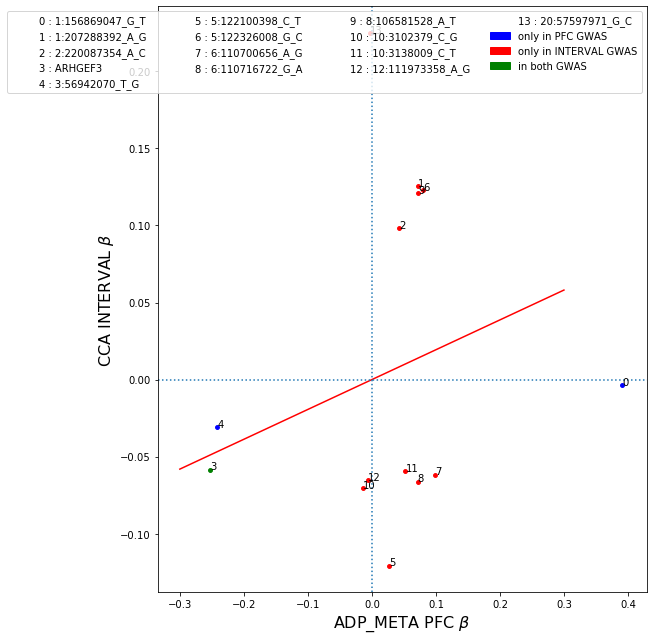

In [12]:
for pheno_pfc in ["ADP_META"]:
    
    #pheno_hv = pheno_pfc.split("_")[0]
    df = pd.merge(gw.loc[gw.pheno == pheno_hv],
                  gw_pfc.loc[gw_pfc.pheno == pheno_pfc],
                  #left_on=("SNP"),
                  #right_on=("RSID"))
                  left_on=("CHR","BP"),right_on=("CHR","BP"))
    df = df.loc[df.ALLELE1 == df.REF]

    plt.figure(figsize=(9,9))
    PFC_threshold = 7.3
    cond_only_PFC = (df.MLOG10P >= PFC_threshold) & ~df.RSID.isin(significant_HV)
    cond_only_HV = (df.MLOG10P < PFC_threshold) & df.RSID.isin(significant_HV)
    cond_both = (df.MLOG10P >= PFC_threshold) & df.RSID.isin(significant_HV)
    
    df.loc[df.ALT_MINOR,"BETA_y"] *= -1

    plt.scatter(df.loc[cond_only_PFC,"BETA_y"],df.loc[cond_only_PFC,"BETA_x"],c="blue",s=15)
    plt.scatter(df.loc[cond_only_HV ,"BETA_y"],df.loc[cond_only_HV ,"BETA_x"],c="red",s=15)
    plt.scatter(df.loc[cond_both    ,"BETA_y"],df.loc[cond_both    ,"BETA_x"],c="green",s=15)

    plotted_rsIDs = df.loc[cond_only_PFC | cond_only_HV | cond_both,"RSID"].unique().tolist()
    
    
    ID_gene = {}
    legend_elements = []
    for i, SNP in enumerate(plotted_rsIDs):
        row = df.loc[df.RSID == SNP].iloc[0]
        x = row["BETA_y"]
        y = row["BETA_x"]
        plt.text(x,y,"%d" % i)
        try:
            ID_gene[i] = recap.loc[SNP,"genes"]
        except:
            ID_gene[i] = row["ID"]
        legend_elements.append(Patch(facecolor='white', edgecolor='white',
                         label='%d : %s' % (i,ID_gene[i])))
    legend_elements.append(Patch(facecolor='blue', edgecolor='blue',
                         label='only in PFC GWAS'))
    legend_elements.append(Patch(facecolor='red', edgecolor='red',
                         label='only in INTERVAL GWAS'))
    legend_elements.append(Patch(facecolor='green', edgecolor='green',
                         label='in both GWAS'))
    plt.legend(handles=legend_elements,ncol=4)

    plt.plot([-.3,.3],np.sqrt(0.03)/np.sqrt(0.8)*np.array([-.3,.3]),c="red")
    #plt.xlim((-.5,.5))
    #plt.ylim((-.2,.2))
    plt.axvline(0,ls=":")
    plt.axhline(0,ls=":")
    plt.xlabel("%s PFC $\\beta$" % pheno_pfc,fontsize=16)
    plt.ylabel("%s INTERVAL $\\beta$" % pheno_hv,fontsize=16)
    plt.tight_layout()

In [13]:
df.loc[(cond_both | cond_only_PFC | cond_only_HV) & (df.CHR >= 20)]

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA_x,SE_x,...,MAF,ALT_MINOR,REF_COUNT,ALT_COUNT,INFO,BETA_y,SE_y,MLOG10P,POS_y,pheno_y
6846734,rs415064,20,57597971,0,G,C,0.954646,0.002757,0.224716,0.022369,...,0.04552,True,5242.0,250.0,1.0,-0.002972,0.09512,0.01096,2775020437,ADP_META


In [14]:
X = df.loc[(cond_both | cond_only_PFC | cond_only_HV)]
pearsonr(X["BETA_x"],X["BETA_y"])

(0.15297310005322864, 0.601601573823491)

In [15]:
X = df.loc[(cond_both | cond_only_PFC | cond_only_HV) & (df.CHR < 20)]
pearsonr(X["BETA_x"],X["BETA_y"])

(0.23108532932857928, 0.44748838187140694)

In [19]:
pearsonr(df["BETA_x"],df["BETA_y"])

(-0.0005718128853907295, 0.1288747925448399)

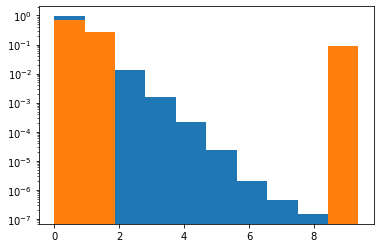

In [20]:
plt.hist(df.MLOG10P,density=True)
plt.hist(df.loc[cond_only_HV | cond_both,"MLOG10P"],density=True)
plt.yscale("log")

In [21]:
df.loc[cond_only_HV | cond_both].sort_values("MLOG10P",ascending=False)

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA_x,SE_x,...,MAF,ALT_MINOR,REF_COUNT,ALT_COUNT,INFO,BETA_y,SE_y,MLOG10P,POS_y,pheno_y
1285356,rs1354034,3,56849749,0,T,C,0.404338,0.007107,-0.058354,0.009479,...,0.38490,False,2114.0,3378.0,1.0000,-0.252900,0.04050,9.37400,549273948,ADP_META
2932729,rs9372251,6,110700656,0,A,G,0.561868,0.045100,-0.061588,0.009349,...,0.44940,True,3023.8,2468.2,0.9751,0.098340,0.04165,1.74000,1172783186,ADP_META
2471405,rs425573,5,122326008,0,G,C,0.670216,0.011027,0.123047,0.009700,...,0.33070,True,3675.7,1816.3,0.9978,0.080300,0.04412,1.16300,1003694099,ADP_META
3800327,rs6993770,8,106581528,0,A,T,0.713156,0.006246,0.120753,0.010056,...,0.28040,True,3952.0,1540.0,1.0000,0.072740,0.04498,0.97550,1498809057,ADP_META
2932758,rs2057150,6,110716722,0,G,A,0.732599,0.100797,-0.066250,0.010802,...,0.28800,True,3910.4,1581.6,0.9848,0.071520,0.04580,0.92690,1172799252,ADP_META
4216669,rs2388595,10,3138009,0,C,T,0.611246,0.006806,-0.059391,0.009343,...,0.36930,True,3464.0,2028.0,1.0000,0.052490,0.04144,0.68760,1682771385,ADP_META
427968,rs17020993,1,207288392,0,A,G,0.879310,0.010467,0.125358,0.013984,...,0.11580,True,4856.0,636.0,1.0000,0.072010,0.06351,0.59040,207288392,ADP_META
2470703,rs6595407,5,122100398,0,C,T,0.443586,0.004695,-0.120646,0.009163,...,0.44620,False,2450.4,3041.6,0.9931,0.027480,0.04128,0.29610,1003468489,ADP_META
1071169,rs72955435,2,220087354,0,A,C,0.911575,0.002326,0.098276,0.016018,...,0.08061,True,5049.3,442.7,0.9974,0.042700,0.07236,0.25570,469325874,ADP_META
4216505,rs11251684,10,3102379,0,C,G,0.176845,0.014603,-0.070441,0.011978,...,0.18530,False,1017.6,4474.4,0.9902,-0.013790,0.05387,0.09800,1682735755,ADP_META
